<a href="https://colab.research.google.com/github/ayushs0911/Projects/blob/main/Malaria__detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Problem Statement
Detecting whether a Blood Sample is infected by Malarial Parasite.  

##Significance of Analysis 
- Malaria is a life-threatening disease caused by parasites that are transmitted to people through the bites of infected female Anopheles mosquitoes. It is preventable and curable.
- In 2021, there were an estimated 247 million cases of malaria worldwide.
- The estimated number of malaria deaths stood at 619 000 in 2021.<br>
Source : [WHO](https://www.who.int/news-room/fact-sheets/detail/malaria#:~:text=Malaria%20is%20a%20life%2Dthreatening,at%20619%20000%20in%202021.)

This Model can help in easy detection of malaria cases. <br>
In remote places, where doctors and technicians are not available, this Deep learning model can aid in faster diagnosis and can save lives. 


##Importing Libraries

In [ ]:
import tensorflow as tf### models
import numpy as np### math computations
import matplotlib.pyplot as plt### plots
import sklearn### machine learning library
import cv2## image processing
from sklearn.metrics import confusion_matrix, roc_curve### metrics
import seaborn as sns### visualizations
import datetime
import io
import os
import random
from google.colab import files
from PIL import Image
import albumentations as A
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, InputLayer, BatchNormalization, Input, Dropout, RandomFlip, RandomRotation, Resizing, Rescaling, RandomContrast
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives, Precision, Recall, AUC, binary_accuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, CSVLogger, EarlyStopping, LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers  import L2, L1
from tensorboard.plugins.hparams import api as hp
from google.colab import drive

##Data Loading 

In [ ]:
dataset, dataset_info = tfds.load('malaria',
                                  with_info = True,
                                  as_supervised = True, 
                                  shuffle_files = True,
                                  split = ['train'])

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /root/tensorflow_datasets/malaria/1.0.0.incompleteIJ4YWL/malaria-train.tfrecord*...:   0%|          …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


In [ ]:
#information about the data
dataset_info

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_path='/root/tensorflow_datasets/malaria/1.0.0',
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasite detection in thin blood smear i

In [ ]:
for data in dataset[0].take(1):
  print(data)

(<tf.Tensor: shape=(103, 103, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)>, <tf.Tensor: shape=(), dtype=int64, numpy=0>)


Dataset contains only one split `train`. We have to split the data into train, test and validation ratio. <br>
Defining function for the same :


In [ ]:
def splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
  DATASET_SIZE = len(dataset)

  train_dataset = dataset.take(int(TRAIN_RATIO * DATASET_SIZE))

  val_test_dataset = dataset.skip(int(TRAIN_RATIO * DATASET_SIZE))
  val_dataset = val_test_dataset.take(int(VAL_RATIO * DATASET_SIZE))
  
  test_dataset = val_test_dataset.skip(int(VAL_RATIO * DATASET_SIZE))

  return train_dataset, val_dataset, test_dataset

In [ ]:
# Splitting the data into 80:10:10 ratio 

TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

train_dataset, val_dataset, test_dataset = splits(dataset[0], TRAIN_RATIO, VAL_RATIO, TEST_RATIO)

In [ ]:
len(train_dataset), len(val_dataset), len(test_dataset)

(22046, 2755, 2757)

In [ ]:
list(train_dataset.take(1))

[(<tf.Tensor: shape=(151, 115, 3), dtype=uint8, numpy=
  array([[[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
  
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
  
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
  
         ...,
  
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
  
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
  
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]]], dtype=uint8)>,
  <tf.Tensor: shape=(), dtype=int64, numpy=1>

##Dataset Visualization 

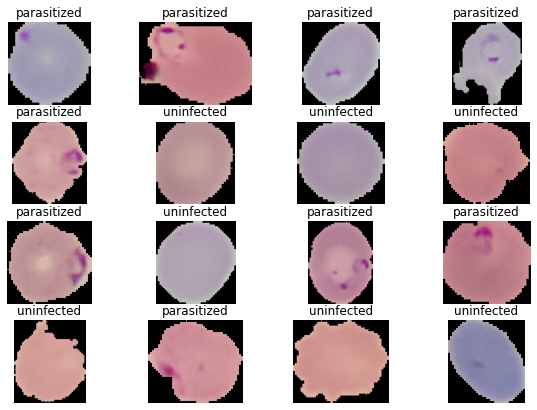

In [ ]:
plt.figure(figsize = (10,7))
for i, (image, label) in enumerate(train_dataset.take(16)):
  ax = plt.subplot(4,4,i+1)
  
  plt.imshow(image)
  plt.title(dataset_info.features['label'].int2str(label))
  plt.axis('off')

In [ ]:
dataset_info.features['label'].int2str(1)

'uninfected'

##Data Preprocessing

###Data Augmentation

In [ ]:
def visualize(original, augmented):
  plt.subplot(1,2,1)
  plt.imshow(original)
  plt.subplot(1,2,2)
  plt.imshow(augmented)

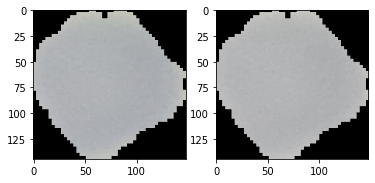

In [ ]:
original_image, label = next(iter(train_dataset))
augmented_image = tf.image.adjust_saturation(original_image,
                                             saturation_factor = 0.3)
visualize(original_image, augmented_image)

In [ ]:
#tf.image resize 
IM_SIZE = 224
original_image, label = next(iter(train_dataset))
@tf.function
def resize_rescale(image, label):
  return tf.image.resize(image, (IM_SIZE,IM_SIZE))/255.0, label

a, b = resize_rescale(original_image, label)

In [ ]:
##tf.keras.layer resizing and rescaling 
resize_rescale_layers = tf.keras.Sequential([
    Resizing(IM_SIZE, IM_SIZE),
    Rescaling(1./255),
])

In [ ]:
#tf.image augment 
@tf.function 
def augment(image, label):
  image, label = resize_rescale(image, label)
  image = tf.image.rot90(image)

  #not using saturation adjustment
  #image = tf.image.adjust_saturation(image, saturation_factor = 0.3)

  image = tf.image.flip_left_right(image)

  return image, label

In [ ]:
class RotNinety(Layer):
  def __init__(self):
    super().__init__()

    @tf.function
    def call(self, image):
      return tf.image.rot90(image)

In [ ]:
## tf.keras.layer augment 
augment_layers = tf.keras.Sequential([
    RandomRotation(factor = (0.25, 0.2501),),
    RandomFlip(mode = 'horizontal'),
    RandomContrast(factor = 0.1),
])

@tf.function 
def augment_layer(image, label):
  return augment_layers(resize_rescale_layers(image), training = True), label

###Data Loading

In [ ]:
BATCH_SIZE = 32

In [ ]:
test_dataset = (test_dataset
                .map(resize_rescale, 
                     num_parallel_calls = tf.data.AUTOTUNE))
test_dataset

<ParallelMapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
train_dataset = (train_dataset
                 .shuffle(buffer_size = 1024, reshuffle_each_iteration = True)
                 .map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)
                 .batch(BATCH_SIZE)
                 .prefetch(tf.data.AUTOTUNE)
)

val_dataset = (val_dataset
               .shuffle(buffer_size = 32)
               .map(resize_rescale, num_parallel_calls = tf.data.AUTOTUNE)
               .batch(BATCH_SIZE))

###Mixup Data Augmentation 
We'll mix up the features and their corresponding labels.
- Neural networks are prone to memorizing corrupt labels. mixup relaxes this by combining different features with one another (same happens for the labels too) so that a network does not get overconfident about the relationship between the features and their labels.

- Specifically useful when we are not sure about selecting a set of augmentation transforms for a given dataset.

To perform the mixup routine, we create new virtual datasets using the training data from the same dataset, and apply a lambda value within the [0, 1] range sampled from a Beta distribution — such that, for example, `new_x = lambda * x1 + (1 - lambda) * x2` (where `x1` and `x2` are images) and the same equation is applied to the labels as well.

-----------------
The Beta distribution is defined over the `(0, 1)` interval using parameters concentration1 (aka 'alpha') and concentration0 (aka 'beta').

In [ ]:
train_dataset_1 = train_dataset.shuffle(buffer_size = 4096).map(resize_rescale,
                                                                num_parallel_calls = tf.data.AUTOTUNE)
train_dataset_2 = train_dataset.shuffle(buffer_size = 4096).map(resize_rescale,
                                                                num_parallel_calls = tf.data.AUTOTUNE)
mixed_dataset = tf.data.Dataset.zip((train_dataset_1, train_dataset_2))

In [ ]:
def mixup(train_dataset_1, train_dataset_2):
  (image_1, label_1), (image_2, label_2) = train_dataset_1, train_dataset_2
  
  lamda = tfp.distributions.Beta(0.2,0.2)
  lamda = lamda.sample(1)[0]

  image = lamda*image_1 + (1-lamda)*image_2
  label = lamda*tf.cast(label_1, dtype = tf.float32) + (1-lamda)*tf.cast(label_2, dtype = tf.float32)
  return image, label

> Note that here , we are combining two images to create a single one. Theoretically, we can combine as many we want but that comes at an increased computation cost. In certain cases, it may not help improve the performance as well.

In [ ]:
BATCH_SIZE = 32

train_dataset_mixup = (mixed_dataset
                       .shuffle(buffer_size = 4096,
                                reshuffle_each_iteration = True)
                       .map(mixup, num_parallel_calls = tf.data.AUTOTUNE)
                       .batch(BATCH_SIZE)
                       .prefetch(tf.data.AUTOTUNE)
)

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))


In [ ]:
train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
train_dataset_mixup

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, None), dtype=tf.float32, name=None))>

In [ ]:
# plt.figure(figsize = (10,7))
# for i, (image, label) in enumerate(train_dataset_mixup.take(4)):
#   ax = plt.subplot(4,4,i+1)
  
#   plt.imshow(image)
#   plt.title(dataset_info.features['label'].int2str(label))
#   plt.axis('off')

###Cutmix Data Augmentation 

CutMix is a data augmentation technique that addresses the issue of information loss and inefficiency present in regional dropout strategies. Instead of removing pixels and filling them with black or grey pixels or Gaussian noise, you replace the removed regions with a patch from another image, while the ground truth labels are mixed proportionally to the number of pixels of combined images

In [ ]:
def box(lamda):
  
  r_x = tf.cast(tfp.distributions.Uniform(0, IM_SIZE).sample(1)[0], dtype = tf.int32)
  r_y = tf.cast(tfp.distributions.Uniform(0, IM_SIZE).sample(1)[0], dtype = tf.int32)

  r_w = tf.cast(IM_SIZE*tf.math.sqrt(1-lamda), dtype = tf.int32)
  r_h = tf.cast(IM_SIZE*tf.math.sqrt(1-lamda), dtype = tf.int32)

  r_x = tf.clip_by_value(r_x - r_w//2, 0, IM_SIZE)
  r_y = tf.clip_by_value(r_y - r_h//2, 0, IM_SIZE)

  x_b_r = tf.clip_by_value(r_x + r_w//2, 0, IM_SIZE)
  y_b_r = tf.clip_by_value(r_y + r_h//2, 0, IM_SIZE)

  r_w = x_b_r - r_x
  if(r_w == 0):
    r_w  = 1

  r_h = y_b_r - r_y
  if(r_h == 0):
    r_h = 1

  return r_y, r_x, r_h, r_w

In [ ]:
def cutmix(train_dataset_1, train_dataset_2):
  (image_1,label_1), (image_2, label_2) = train_dataset_1, train_dataset_2

  lamda = tfp.distributions.Beta(0.2,0.2)
  lamda = lamda.sample(1)[0]
  
  r_y, r_x, r_h, r_w = box(lamda)
  crop_2 = tf.image.crop_to_bounding_box(image_2, r_y, r_x, r_h, r_w)
  pad_2 = tf.image.pad_to_bounding_box(crop_2, r_y, r_x, IM_SIZE, IM_SIZE)

  crop_1 = tf.image.crop_to_bounding_box(image_1, r_y, r_x, r_h, r_w)
  pad_1 = tf.image.pad_to_bounding_box(crop_1, r_y, r_x, IM_SIZE, IM_SIZE)

  image = image_1 - pad_1 + pad_2

  lamda = tf.cast(1- (r_w*r_h)/(IM_SIZE*IM_SIZE), dtype = tf.float32)
  label = lamda*tf.cast(label_1, dtype = tf.float32) + (1-lamda)*tf.cast(label_2, dtype = tf.float32)

  return image, label

In [ ]:
BATCH_SIZE = 32

train_dataset_cutmix = (mixed_dataset
                       .shuffle(buffer_size = 4096,
                                reshuffle_each_iteration = True)
                       .map(cutmix, num_parallel_calls = tf.data.AUTOTUNE)
                       .batch(BATCH_SIZE)
                       .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
# plt.figure(figsize = (10,7))
# for i, (image, label) in enumerate(train_dataset_cutmix.take(4)):
#   ax = plt.subplot(4,4,i+1)
  
#   plt.imshow(image)
#   plt.title(dataset_info.features['label'].int2str(label))
#   plt.axis('off')

###Albumenations 
Albumentations is a Python library for image augmentation. Image augmentation is used in deep learning and computer vision tasks to increase the quality of trained models. The purpose of image augmentation is to create new training samples from the existing data.

**Why Albumenations??**
- Supports all common computer vision tasks such as classification, semantic segmentation, instance segmentation, object detection, and pose estimation.
- Simple unified API to work with all data types: images (RBG-images, grayscale images, multispectral images), segmentation masks, bounding boxes, and keypoints.
- The library contains more than 70 different augmentations to generate new training samples from the existing data.
- Albumentations is fast. 
 


To integrate albumentations into our tensorflow pipeline we can create two functions :

- Pipeline to apply `augmentation`.
- tra function that calls the above function and pass in our data through the pipeline. We can then wrap our 2nd Function under tf.numpy_function 

In [ ]:
transforms = A.Compose(
    [
        A.Resize(IM_SIZE, IM_SIZE),
        A.OneOf([A.HorizontalFlip(),
                 A.VerticalFlip(),], p = 0.3),

        A.RandomRotate90(),
        #A.RandomGridShuffle(grid = (3,3), always_apply = False, p =0.5),
        A.RandomBrightnessContrast(brightness_limit = 0.2,
                                   contrast_limit = 0.2,
                                   always_apply = False, 
                                   p = 0.5),
        A.Cutout(num_holes = 8, 
                 max_h_size = 8,
                 max_w_size = 8, 
                 fill_value = 0, 
                 always_apply = False, 
                 p =0.5),
        A.Sharpen(alpha = (0.2,0.5), 
                  lightness = (0.5,1.0), 
                  always_apply = False, p =0.5)
    ]
)

/usr/local/lib/python3.9/dist-packages/albumentations/augmentations/dropout/cutout.py:50: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


In [ ]:
def aug_albument(image):
  data = {"image": image}
  image = transforms(**data)
  image = image['image']
  image = tf.cast(image/255., tf.float32)
  return image

In [ ]:
def process_data(image, label):
    aug_img = tf.numpy_function(func=aug_albument, inp=[image], Tout=tf.float32)
    return aug_img, label

In [ ]:
train_dataset_alb = (
    train_dataset
    .shuffle(buffer_size = 1024, reshuffle_each_iteration = True)
    .map(process_data)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
train_dataset_alb

<PrefetchDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=(None, None), dtype=tf.int64, name=None))>

# Model Creation and Training

In [ ]:
feature_extractor_seq_model = tf.keras.Sequential([
                             InputLayer(input_shape = (IM_SIZE, IM_SIZE, 3)),

                             Conv2D(filters = 6, kernel_size = 3, strides=1, padding='valid', activation = 'relu'),
                             BatchNormalization(),
                             MaxPool2D (pool_size = 2, strides= 2),

                             Conv2D(filters = 16, kernel_size = 3, strides=1, padding='valid', activation = 'relu'),
                             BatchNormalization(),
                             MaxPool2D (pool_size = 2, strides= 2),

                             

])
feature_extractor_seq_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 6)       168       
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 6)      24        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 6)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_1 (Batc  (None, 109, 109, 16)     64        
 hNormalization)                                                 
                                                      

In [ ]:
func_input = Input(shape = (IM_SIZE, IM_SIZE, 3), name = "Input Image")

x = feature_extractor_seq_model(func_input)

x = Flatten()(x)

x = Dense(100, activation = "relu")(x)
x = BatchNormalization()(x)

x = Dense(10, activation = "relu")(x)
x = BatchNormalization()(x)

func_output = Dense(1, activation = "sigmoid")(x)

model_1 = Model(func_input, func_output, name = "Lenet_Model")
model_1.summary()

Model: "Lenet_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 54, 54, 16)        1136      
                                                                 
 flatten (Flatten)           (None, 46656)             0         
                                                                 
 dense (Dense)               (None, 100)               4665700   
                                                                 
 batch_normalization_2 (Batc  (None, 100)              400       
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 10)                1010      
                                                       

##Callbacks

**CSVLogger**

In [ ]:
csv_callback = CSVLogger(
    'logs.csv', separator = ',', append = True
)

**Early Stopping**

In [ ]:
es_callback = EarlyStopping(
    monitor = 'val_loss',
    min_delta = 0,
    patience =3,
    verbose =1,
    mode = 'auto',
    baseline = None, 
    restore_best_weights = False
)

**Model Checkpointing**

In [ ]:
checkpoint_path = "model_checkpoints/cp.ckpt" # saving weights requires ".ckpt" extension
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_accuracy", # save the model weights with best validation accuracy
                                                      save_best_only=True, # only save the best weights
                                                      save_weights_only=True, # only save model weights (not whole model)
                                                      verbose=0) # don't print out whether or not model is being saved

**ReduceLearningRateOnPlateau**

In [ ]:
plateau_callback = ReduceLROnPlateau(
    monitor='val_accuracy', factor=0.1, patience=5, verbose=1
)

##Training

In [ ]:

import os 
if not os.path.exists('helper_functions.py'):
  !wget https://raw.githubusercontent.com/ayushs0911/Projects/main/helper_functions.py
else:
  print("[INFO] 'helper_functions.py' already exists.skipping download.")

--2023-03-26 05:20:33--  https://raw.githubusercontent.com/ayushs0911/Projects/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-03-26 05:20:33 (76.8 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, calculate_results, make_confusion_matrix

In [ ]:
model_1.compile(optimizer = Adam(),
                    loss = BinaryCrossentropy(),
                    metrics = ['accuracy'])

In [ ]:
history_1 = model_1.fit(train_dataset,
                               epochs =20,
                               steps_per_epoch = len(train_dataset),
                               validation_data = val_dataset,
                               validation_steps = len(val_dataset),
                               callbacks = [csv_callback,
                                            es_callback,
                                            model_checkpoint,
                                            plateau_callback,
                                            create_tensorboard_callback('trainning_logs', '1st test')])

Saving TensorBoard log files to: trainning_logs/1st test/20230326-052423
Epoch 1/20
689/689 [==============================] - 139s 196ms/step - loss: 0.2394 - accuracy: 0.9102 - val_loss: 0.7825 - val_accuracy: 0.6976 - lr: 0.0010
Epoch 2/20
689/689 [==============================] - 127s 183ms/step - loss: 0.1947 - accuracy: 0.9290 - val_loss: 0.2929 - val_accuracy: 0.9005 - lr: 0.0010
Epoch 3/20
689/689 [==============================] - 134s 194ms/step - loss: 0.1651 - accuracy: 0.9398 - val_loss: 0.2006 - val_accuracy: 0.9328 - lr: 0.0010
Epoch 4/20
689/689 [==============================] - 134s 194ms/step - loss: 0.1512 - accuracy: 0.9444 - val_loss: 0.1882 - val_accuracy: 0.9397 - lr: 0.0010
Epoch 5/20
689/689 [==============================] - 126s 182ms/step - loss: 0.1300 - accuracy: 0.9518 - val_loss: 0.2001 - val_accuracy: 0.9358 - lr: 0.0010
Epoch 6/20
689/689 [==============================] - 135s 195ms/step - loss: 0.1196 - accuracy: 0.9549 - val_loss: 0.2500 - val_acc

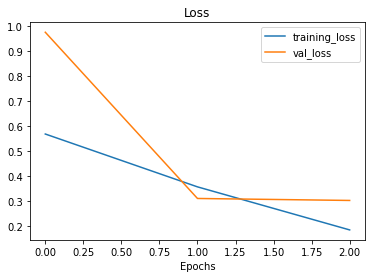

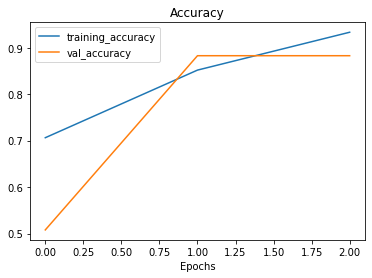

In [ ]:
plot_loss_curves(history_1)

In [ ]:
model_1.load_weights(checkpoint_path)

In [ ]:
model_1.evaluate(test_dataset.batch(1))

2757/2757 [==============================] - 21s 4ms/step - loss: 0.1990 - accuracy: 0.9311


[0.19896475970745087, 0.9310845136642456]

**Preparing Image and Labels for confusion matrix and roc curve.** 

In [ ]:
labels = []
inp = []

for x,y in test_dataset.as_numpy_iterator():
  labels.append(y)
  inp.append(x)

In [ ]:
np.array(inp).shape

(2757, 224, 224, 3)

In [ ]:
y_pred = model_1.predict(np.array(inp))

87/87 [==============================] - 1s 14ms/step


In [ ]:
confusion_matrix(y_true = labels,
                  y_pred = tf.round(y_pred))

array([[1261,  134],
       [  54, 1308]])

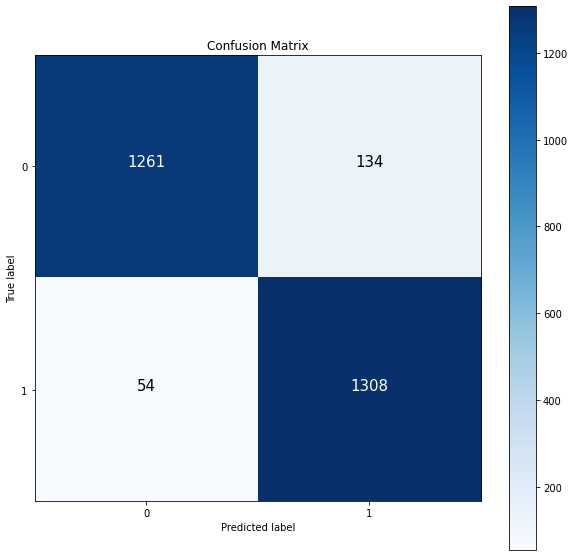

In [ ]:
make_confusion_matrix(y_true = labels,
                  y_pred = tf.round(y_pred))

### ROC Curve 
- ROC Graph shows us the capability of a model to distinguish b/w the classes based on AUC mean score.
- The orange line represents the ROC Curve of a random classifer while a good classifier tries to remain as far away from that line as possible.

Best Threshold=0.779043, G-Mean=0.935


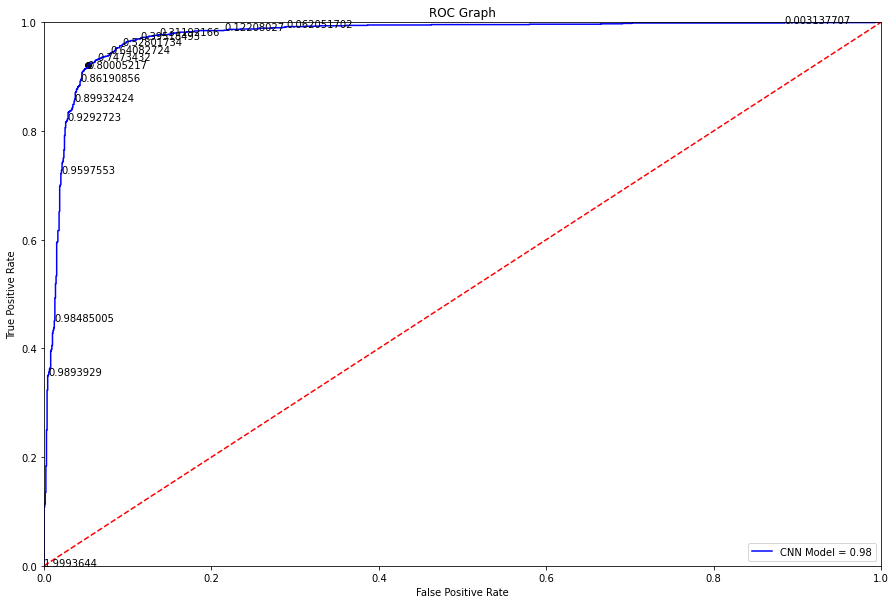

In [ ]:

import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
# probs = model_1.predict(np.array(inp))
# preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(labels, y_pred)
roc_auc = metrics.auc(fpr, tpr)

# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (threshold[ix], gmeans[ix]))

# method I: plt

plt.figure(figsize = (15,10))
plt.title('ROC Graph')
plt.plot(fpr, tpr, 'b', label = 'CNN Model = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])

plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
skip = 20

for i in range(0, len(threshold), skip):
  plt.text(fpr[i], tpr[i], threshold[i])
  
plt.show()

In [ ]:
threshold = 0.779043
y_threshold = []
for i in y_pred:
  if i < threshold:
    y_threshold.append(0)
  else:
    y_threshold.append(1)


In [ ]:
y_threshold[:10]

[1, 0, 0, 0, 0, 0, 0, 1, 0, 1]

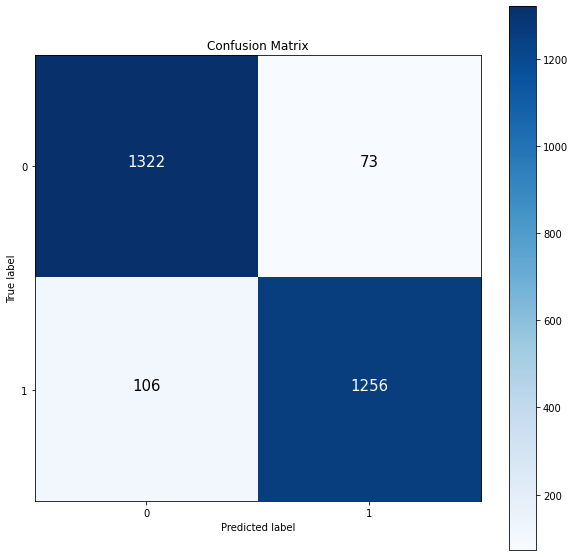

In [ ]:
make_confusion_matrix(y_true = labels,
                  y_pred =y_threshold)

###This new threshold Decreases the `False Positives`
Here False positive is diagosing a person `Uninfected`, despite being `parasatized`. 

1/1 [==============================] - 0s 19ms/step


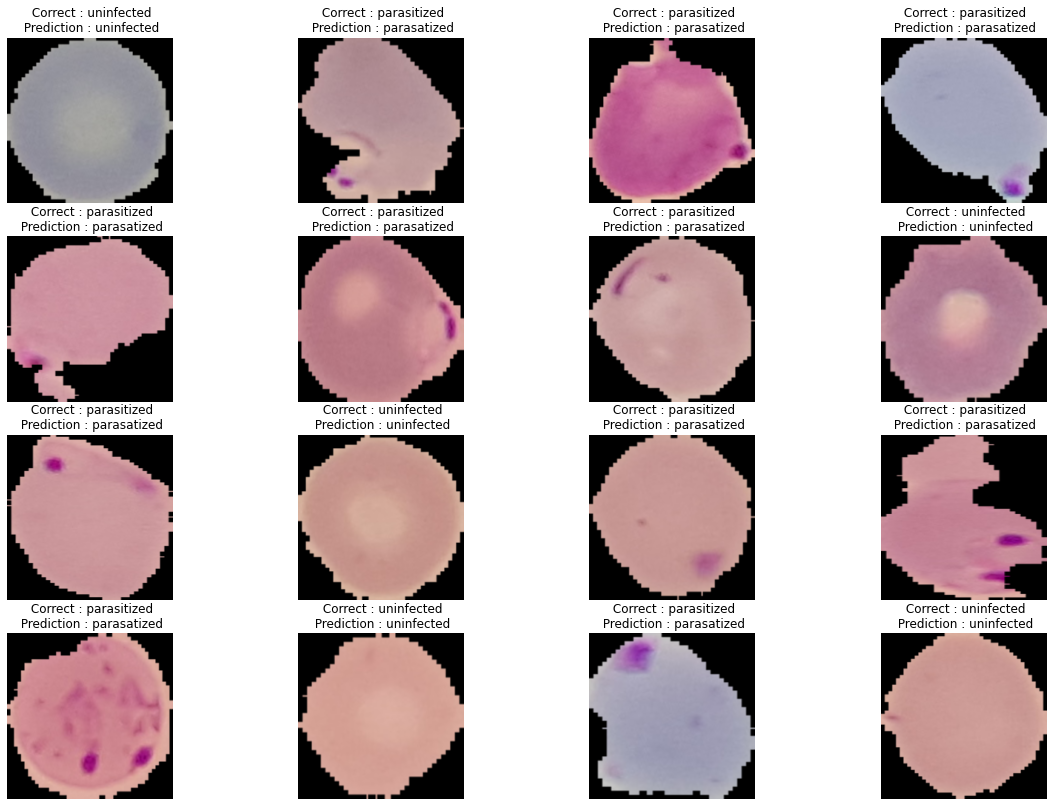

In [ ]:
plt.figure(figsize = (20,14))
classes = ['parasatized', 'uninfected']
for i, (image, label) in enumerate(test_dataset.take(16)):
  ax = plt.subplot(4,4,i+1)
  
  plt.imshow(image)
  p = model_1.predict(tf.expand_dims(image, axis =0))
  plt.title(f" Correct : {dataset_info.features['label'].int2str(label)}\n Prediction : {classes[int(np.round(p))]}")
  plt.axis('off')